# Currency Hedging
Assume that an EUR based investor is investing in EUR and US equities and EUR and
USD denominated zero coupon bonds. The investor has a one year investment horizon.
The investor’s objective is to find the optimal portfolio when allowing hedging of the USD
exposure. The hedging will be performed using one year FX forward contracts that allows
the investor to buy or sell one USD at a pre-specified price in one year.

The market is assumed to be driven by a set of market invariants:

\
\begin{align*}
\Delta X_t = \left(\begin{array}{c}
\Delta \log FX_t \\
\Delta \log V_t^{US,local} \\
\Delta \log V_t^{EUR} \\
\Delta y_t^{EUR,1/12} \\
\Delta y_t^{EUR,1} \\
\Delta y_t^{EUR,3} \\
\Delta y_t^{EUR,5} \\
\Delta y_t^{EUR,7} \\
\Delta y_t^{EUR,10} \\
\Delta y_t^{USD,1/12} \\
\Delta y_t^{USD,1} \\
\Delta y_t^{USD,3} \\
\Delta y_t^{USD,5} \\
\Delta y_t^{USD,7} \\
\Delta y_t^{USD,10}
\end{array}\right)
\end{align*}

The time step is assumed to be one week or 1/52 years. $FX_t$ denotes the EUR/USD exchange rate, the number of USD required to buy one EUR, $\log V_t^{US,local}$ denotes the value of US equities measured in USD, $\log V_t^{EUR}$ denotes the value of EUR equities measured in EUR, $y_t^{x,\tau}$ is the $\tau$ year continuously compounded zero coupon yield for the $x$ economy. The whole USD and EUR yield curve is spanned by these two set of zero coupon yields. The yields for any given time to maturity can be obtained by linear interpolation.

The market invariants are normally distributed

$$
\Delta X_t \sim \mathcal{N}(\mu, \Sigma)
$$

The covariance matrix is provided in the file `covariance_matrix.xlsx`. The vector of expectations is given by $\mu = (0, 0.07 \cdot \Delta t, 0.06 \cdot \Delta t, 0^T,0^T)^T$.

## Loading packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Data.Data import covariance_matrix, init_values, cov_matrix, x0, mean_vector, delta_t
from scipy.stats import norm, lognorm
import seaborn as sns

## Question 1
Assume that we are standing at time $t = 0$ with initial values, $x_0$, as specified in `init_values.xlsx`. What is the distribution of $X_1$? Simulate the evolution of $X_t$ with weekly time steps from time zero to the horizon. Visualize the evolution of $\log F{X_t}$.


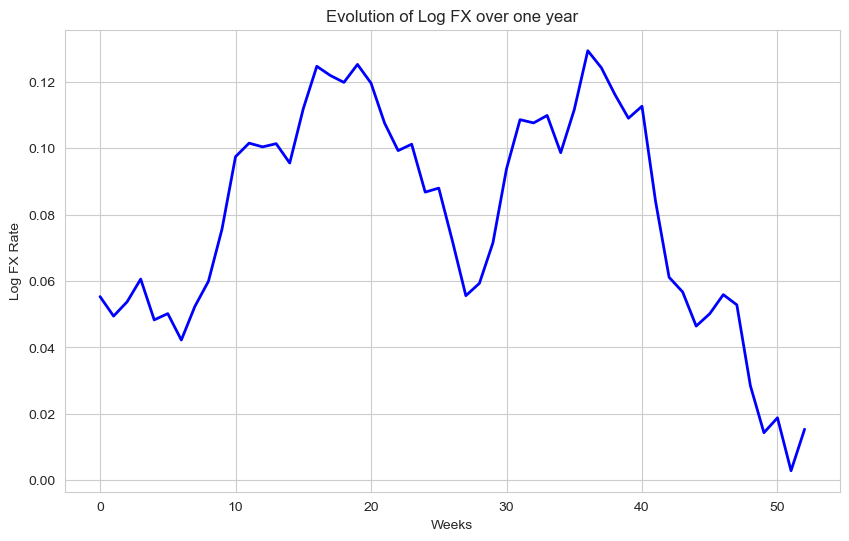

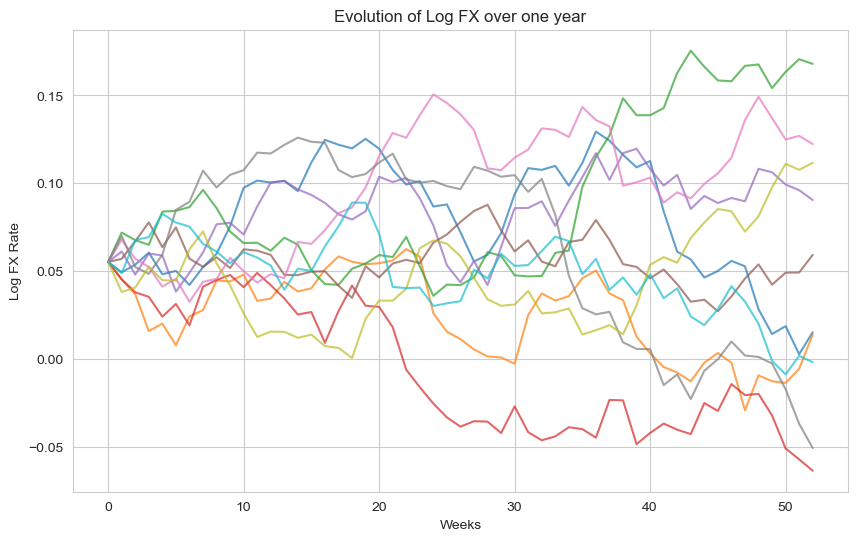

In [3]:
# Simulation parameters
time_horizon = 52  # Weekly steps (1 year)
num_simulations = 10000  # Number of paths

# Simulating X_t evolution
np.random.seed(42)  # For reproducibility
simulations = np.zeros((time_horizon + 1, len(x0), num_simulations))
simulations[0] = x0[:, None]  # Set initial values

for t in range(1, time_horizon + 1):
    # Generate random shocks
    shocks = np.random.multivariate_normal(mean_vector, cov_matrix, num_simulations).T
    # Update simulations for time t
    simulations[t] = simulations[t - 1] + shocks

# Extract log FX evolution
log_fx_simulations = simulations[:, 0, :]  # log(FX_t) is the first variable


# Define the time points (from 0 to 52 weeks)
time_points = range(time_horizon + 1)

# Plot the first simulation path
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(time_points, log_fx_simulations[:, 0], label='Simulation 1', linewidth=2, color='blue')
# Adding labels and title
plt.title('Evolution of Log FX over one year')
plt.xlabel('Weeks')
plt.ylabel('Log FX Rate')
# Show the plot
plt.show()



# Visualize the evolution of log(FX_t)
plt.figure(figsize=(10, 6))
for i in range(min(10, num_simulations)):  # Plot first 10 paths
    plt.plot(range(time_horizon + 1), log_fx_simulations[:, i], alpha=0.7)
plt.title("Evolution of Log FX over one year")
plt.xlabel("Weeks")
plt.ylabel("Log FX Rate")
plt.grid(True)
plt.show()

## Question 2
Obtain the distribution of $V_{1}^{US,local}$. Again, simulate the evolution of $V_{1}^{US,local}$. Compare the simulated data with the true analytical distribution.


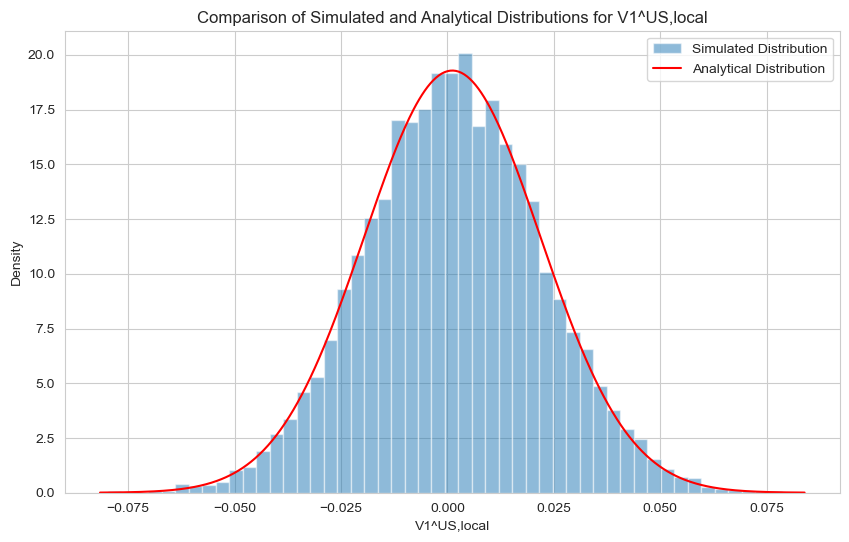

In [4]:
# Parameters and simulation setup
v_us_index = 1
mean_vector = np.array([0.07 * delta_t, 0.06 * delta_t] + [0] * (len(covariance_matrix) - 2))
num_simulations = 10000

#Simulate the distribution of V1^US,local
np.random.seed(42)
simulated_shocks = np.random.multivariate_normal(mean_vector, cov_matrix, num_simulations)
simulated_v1_us_local = x0[v_us_index] + simulated_shocks[:, v_us_index]
#simulated_v1_us_local = np.exp(x0[v_us_index] + simulated_shocks[:, v_us_index])

# Analytical distribution of V1^US,local
mean_v1_us_local = x0[v_us_index] + mean_vector[v_us_index]
#mean_v1_us_local = np.exp(x0[v_us_index] + mean_vector[v_us_index])
std_v1_us_local = np.sqrt(cov_matrix[v_us_index, v_us_index])

# Plot the simulated and analytical distributions
plt.figure(figsize=(10, 6))

# Simulated distribution
plt.hist(simulated_v1_us_local, bins=50, alpha=0.5, label="Simulated Distribution", density=True)

# Analytical normal distribution
x = np.linspace(mean_v1_us_local - 4 * std_v1_us_local, mean_v1_us_local + 4 * std_v1_us_local, 500) #generates the linearly spaced numbers over which the PDF will be calculated.
pdf = norm.pdf(x, loc=mean_v1_us_local, scale=std_v1_us_local) #calculates the PDF
#pdf = lognorm.pdf(x, s=std_v1_us_local, scale=mean_v1_us_local)
plt.plot(x, pdf, label="Analytical Distribution", color='red')

# Labels and legend
plt.title("Comparison of Simulated and Analytical Distributions for V1^US,local")
plt.xlabel("V1^US,local")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Question 3
Explain how to calculate the value of a EUR or USD zero coupon bond based on the vector of yields at a given point in time. What is the distribution of an initial 5 year zero coupon at the horizon? Simulate the evolution of the initial 5 year zero coupon bond. Compare the simulated data with the true analytical distribution.


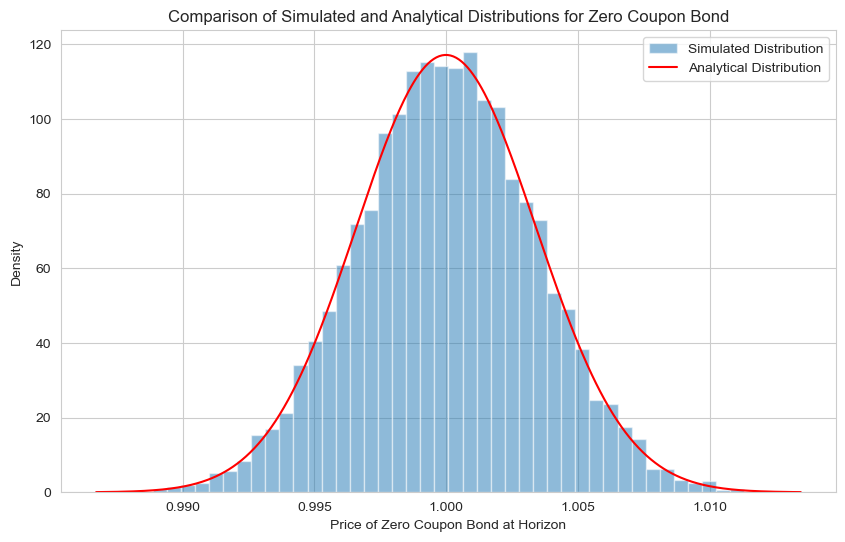

In [5]:
# Parameters
initial_yield_index = 6  # Assuming the 5-year yield is at index 4 in the state vector
tau_initial = 5  # Initial maturity
tau_horizon = 4  # Maturity at horizon
num_simulations = 10000

# Initial values and parameters
initial_yield = x0[initial_yield_index]
mu_yield = mean_vector[initial_yield_index]
sigma_yield = np.sqrt(cov_matrix[initial_yield_index, initial_yield_index])

# Simulate weekly changes in yield
np.random.seed(42)
simulated_yields = np.random.normal(mu_yield, sigma_yield, size=num_simulations)

# Calculate bond prices at horizon
prices_horizon = np.exp(-simulated_yields * tau_horizon)

# Analytical distribution parameters
mu_price = -tau_horizon * mu_yield
sigma_price = np.sqrt(tau_horizon**2 * sigma_yield**2)

# Plot simulated and analytical distributions
plt.figure(figsize=(10, 6))

# Simulated distribution
plt.hist(prices_horizon, bins=50, alpha=0.5, label="Simulated Distribution", density=True)

# Analytical lognormal distribution
x = np.linspace(min(prices_horizon), max(prices_horizon), 500)
pdf = lognorm.pdf(x, s=sigma_price, scale=np.exp(mu_price))
plt.plot(x, pdf, label="Analytical Distribution", color='red')

# Labels and legend
plt.title("Comparison of Simulated and Analytical Distributions for Zero Coupon Bond")
plt.xlabel("Price of Zero Coupon Bond at Horizon")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## Question 4
What is the joint distribution of the vector $P_1 = (F{X_1}, V_{1}^{US,local}, V_{1}^{EUR}, Z_{1}^{USD 4Y,local}, Z_{1}^{EUR 4Y})^T$? Here $Z_{1}^{USD 4Y,local}$ denotes a 4 year USD zero coupon bond such the investor initially has bought a 5 year zero coupon bond.


In [6]:
#Given parameters:
mu = mean_vector
Sigma = cov_matrix
time_steps = 52

#Calculate mean and covariance matrix of X1:
mean_X1 = x0 + time_steps * mu
cov_X1 = time_steps * Sigma

#Define indices for P1 components in X1:
log_FX_index = 0
log_V_US_index = 1
log_V_EUR_index = 2
y_US_3_index = 11
y_US_5_index = 12
y_EUR_3_index = 5
y_EUR_5_index = 6

##Analytical transformations for P1 components##
#The EUR/USD FX rate:
    #The log FX rate:
mean_log_FX1 = mean_X1[log_FX_index]
var_log_FX1 = cov_X1[log_FX_index, log_FX_index] #The log variance of the EUR/USD FX rate at time 1 = 0.005864534599574461

    #The lognormal FX rate:
mean_FX1=np.exp(mean_log_FX1+(var_log_FX1/2)) #The mean of the EUR/USD FX rate at time 1 = 1.0599535146393084
var_FX1=(np.exp(var_log_FX1)-1)*np.exp(2*mean_log_FX1+var_log_FX1) #The variance of the EUR/USD FX rate at time 1 = 0.006608171129626716


#The value of the US equity (local):
    #log mean and variance:
mean_log_V1_us_local = mean_X1[log_V_US_index]
var_log_V1_us_local = cov_X1[log_V_US_index, log_V_US_index]

    #lognormal mean and variance:
mean_V1_us_local=np.exp(mean_log_V1_us_local+(var_log_V1_us_local/2))
var_V1_us_local=(np.exp(var_log_V1_us_local)-1)*np.exp(2*mean_log_V1_us_local+var_log_V1_us_local)


#The value of the EU equity:
    #log mean and variance:
mean_log_V1_eur = mean_X1[log_V_EUR_index]
var_log_V1_eur = cov_X1[log_V_EUR_index, log_V_EUR_index]

    #lognormal mean and variance:
mean_v1_eur=np.exp(mean_log_V1_eur+(var_log_V1_eur/2))
var_v1_eur=(np.exp(var_log_V1_eur)-1)*np.exp(2*mean_log_V1_eur+var_log_V1_eur)
#print(mean_v1_eur,var_v1_eur)


#Yield and price for 4-year bond:
#US bond yield:
    #mean:
mean_y1_us_4 = mean_X1[y_US_3_index] + (4 - 3) / (5 - 3) * (mean_X1[y_US_5_index] - mean_X1[y_US_3_index])

    #variance:
var_y1_us_3=cov_X1[y_US_3_index, y_US_3_index]
var_y1_us_5=cov_X1[y_US_5_index, y_US_5_index]
var_y1_us_4=var_y1_us_3+(4-3)/(5-3)*(var_y1_us_5-var_y1_us_3)

#US bond price:
t=4 #Time to maturity
mean_z1_us_4=np.exp(-mean_y1_us_4*t+(t**2*var_y1_us_4)/2)
var_z1_us_4=np.exp(-2*t*mean_y1_us_4+(t**2)*var_y1_us_4)*(np.exp((t**2)*(var_y1_us_4))-1)


#EU bond yield:
    #mean:
mean_y1_eu_4=mean_X1[y_EUR_3_index]+(4-3)/(5-3)*(mean_X1[y_EUR_5_index]-mean_X1[y_EUR_3_index])

    #variance:
var_y1_eu_3=cov_X1[y_EUR_3_index, y_EUR_3_index]
var_y1_eu_5=cov_X1[y_EUR_5_index, y_EUR_5_index]
var_y1_eu_4=var_y1_eu_3+(4-3)/(5-3)*(var_y1_eu_5-var_y1_eu_3)

#EU bond price:
t=4
mean_z1_eu_4=np.exp(-mean_y1_eu_4*t+(t**2*var_y1_eu_4)/2)
var_z1_eu_4=np.exp(-2*t*mean_y1_eu_4+(t**2)*var_y1_eu_4)*(np.exp((t**2)*(var_y1_eu_4))-1)


#Construct H1 vector:
mean_log=[mean_log_FX1, mean_log_V1_us_local, mean_log_V1_eur, mean_y1_us_4, mean_y1_eu_4]
print(mean_log)


#Construct the mean P1 vector:
mean_P1 = np.array([mean_FX1, mean_V1_us_local, mean_v1_eur, mean_z1_us_4, mean_z1_eu_4])
print(mean_P1)


#Interpolating and Filtering the covariance matrix:
usd_3y_5y=covariance_matrix.loc[["3Y USD", "5Y USD"]]
eur_3y_5y=covariance_matrix.loc[["3Y EUR", "5Y EUR"]]

#Interpolating the 4-year yields:
usd_4y=usd_3y_5y.loc["3Y USD"]+(usd_3y_5y.loc["5Y USD"]-usd_3y_5y.loc["3Y USD"])*(4-3)/(5-3)
eur_4y=eur_3y_5y.loc["3Y EUR"]+(eur_3y_5y.loc["5Y EUR"]-eur_3y_5y.loc["3Y EUR"])*(4-3)/(5-3)

#Add to covariance matrix:
    #rows
covariance_matrix.loc["4Y USD"]=usd_4y
covariance_matrix.loc["4Y EUR"]=eur_4y

    #columns
covariance_matrix["4Y USD"]=usd_4y
covariance_matrix["4Y EUR"]=eur_4y

#Interpolate the 4-year bond yield variables:
covariance_matrix.loc["4Y USD","4Y USD"]=usd_3y_5y.loc["3Y USD", "3Y USD"]+(usd_3y_5y.loc["5Y USD", "5Y USD"]-usd_3y_5y.loc["3Y USD", "3Y USD"])*(4-3)/(5-3)
covariance_matrix.loc["4Y EUR","4Y EUR"]=eur_3y_5y.loc["3Y EUR", "3Y EUR"]+(eur_3y_5y.loc["5Y EUR", "5Y EUR"]-eur_3y_5y.loc["3Y EUR", "3Y EUR"])*(4-3)/(5-3)

#Interpolate cross-covariances:
cov_4y_us_eur=covariance_matrix.loc["3Y USD", "3Y EUR"]+(covariance_matrix.loc["5Y USD", "5Y EUR"]-covariance_matrix.loc["3Y USD", "3Y EUR"])*(4-3)/(5-3)
covariance_matrix.loc["4Y USD", "4Y EUR"]=cov_4y_us_eur
covariance_matrix.loc["4Y EUR", "4Y USD"]=cov_4y_us_eur

#Filtering:
required_variables=["fx_spot","EQV US", "EQV EUR", "4Y USD", "4Y EUR"]
filtered_covariance_matrix=covariance_matrix.loc[required_variables, required_variables]

#Covariance matrix to t=1:
cov_mat_fil1=filtered_covariance_matrix*52

#Making the covariance matrix lognormal:
log_cov=cov_mat_fil1.to_numpy()

def covariance_conversion(mean, covariance, T=4):
    n=len(mean)
    J=np.eye(n)

    #log to lognormal for variables 0-2:
    for i in range(3):
        J[i,i]=np.exp(mean[i]+0.5*covariance[i,i])

    #Yield to bond price for variables 3-4:
    z_us=np.exp(-mean[3]*T)
    z_eur=np.exp(-mean[4]*T)
    J[3,3]=-T*z_us
    J[4,4]=-T*z_eur

    #Full transformation of the covariance matrix:
    cov_P1 = J @ covariance @ J.T

    return cov_P1

cov_P1=covariance_conversion(mean_log, log_cov, 4)

variables=["FX t1", "EQV US Local t1", "EQV EUR t1", "Z4 USD Local t1", "Z4 EUR t1"]
cov_P1=pd.DataFrame(cov_P1, index=variables, columns=variables)

#Verify that the covariance matrix is positice semi-definite:
eigenvalues=np.linalg.eigvals(cov_P1.values)
is_positive_semi_definite=np.all(eigenvalues>=0)
is_positive_semi_definite, eigenvalues

#The final distribution of the P1 vector:
mean_P1, cov_P1


"""#Export to Excel:
mean_P1_excel=pd.DataFrame(mean_P1, index=variables, columns=["Mean"])
mean_P1_excel.to_excel("mean_P1.xlsx")
cov_P1.to_excel("cov_P1.xlsx")"""



[0.12529278574870878, 0.060000000000000005, 0.0, 0.03780754660483733, 0.01987982335596815]
[1.13680882 1.0737189  1.01217518 0.86005393 0.92382766]


'#Export to Excel:\nmean_P1_excel=pd.DataFrame(mean_P1, index=variables, columns=["Mean"])\nmean_P1_excel.to_excel("mean_P1.xlsx")\ncov_P1.to_excel("cov_P1.xlsx")'

## Question 5
What is the distribution of the vector $P_{1}^{EUR} = (\frac{1}{F{X_1}}, V_{1}^{US}, V_{1}^{EUR}, Z_{1}^{USD 4Y}, Z_{1}^{EUR 4Y})^T$ where all values are in EUR? Compare the simulated data with the true analytical distribution for $V_{1}^{US}$.


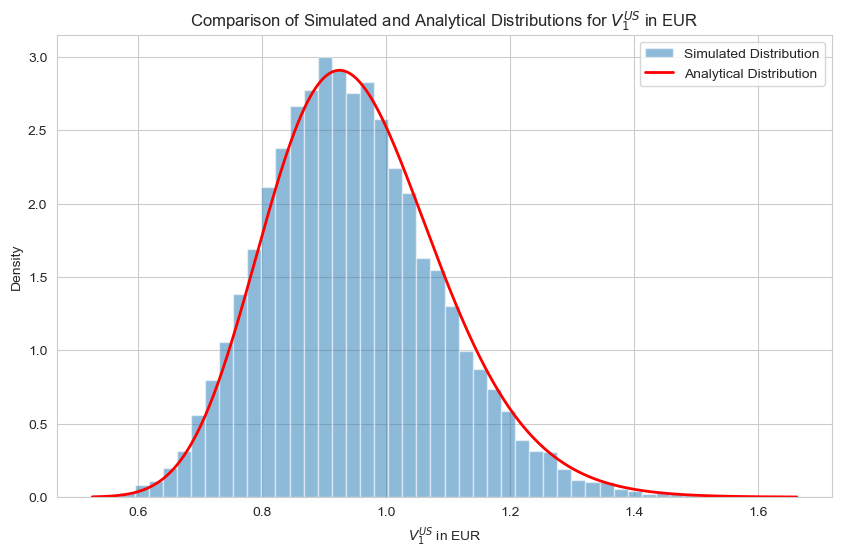

In [7]:
#Converting the covariance matrix to EUR:
def convert_covariance_to_EUR(mean, covariance):
    FX_1=mean[0]
    v1_us_local=mean[1]
    z4_us=mean[3]

    n=len(mean)
    J=np.eye(n)

    J[0,0]=-1/(FX_1**2)

    J[1,0]=-v1_us_local/(FX_1**2)
    J[1,1]=1/FX_1

    J[3,0]=-z4_us/(FX_1**2)
    J[3,3]=1/FX_1

    cov_P1_eur= J @ covariance @ J.T

    return cov_P1_eur

cov_P1_eur=convert_covariance_to_EUR(mean_P1, cov_P1)
cov_P1_eur.index = ["1/FX t1", "EQV US t1", "EQV EUR t1", "Z4 USD t1", "Z4 EUR t1"]
cov_P1_eur.columns = ["1/FX t1", "EQV US t1", "EQV EUR t1", "Z4 USD t1", "Z4 EUR t1"]

#Verifying the covariance matrix is positive semi-definite:
eigenvalues=np.linalg.eigvals(cov_P1_eur.values)
is_positive_semi_definite=np.all(eigenvalues>=0)
is_positive_semi_definite, eigenvalues

#Converting the mean vector to EUR:
    # Extract individual means from the P1 vector
fx_mean = mean_P1[0]  # FX mean
v_us_mean = mean_P1[1]  # USD stock mean
v_eur_mean = mean_P1[2]  # EUR stock mean (unchanged)
z_usd_4y_mean = mean_P1[3]  # USD bond mean
z_eur_4y_mean = mean_P1[4]  # EUR bond mean (unchanged)

    # Convert each component
mu_1 = 1 / fx_mean  # 1 / FX_1
mu_2 = v_us_mean / fx_mean  # V_US_LOCAL / FX_1
mu_3 = v_eur_mean  # V_EUR (unchanged)
mu_4 = z_usd_4y_mean / fx_mean  # Z_4Y_USD / FX_1
mu_5 = z_eur_4y_mean  # Z_4Y_EUR (unchanged)

mean_P1_eur=np.array([mu_1, mu_2, mu_3, mu_4, mu_5])


#The distribution of the P1 EUR:
mean_P1_eur, cov_P1_eur


#Compare analytical distribution for V_US with the simulated distribution:
v1_us_mean=mean_P1_eur[1]
v1_us_var=cov_P1_eur.loc["EQV US t1", "EQV US t1"]

# Number of simulations
num_simulations = 10000
np.random.seed(42)  # For reproducibility

# Simulate V1^US in EUR
simulated_v1_us_eur = np.random.lognormal(
    mean=np.log(v1_us_mean) - 0.5 * v1_us_var,  # Adjust mean for lognormal distribution
    sigma=np.sqrt(v1_us_var),
    size=num_simulations
)

# Analytical distribution parameters
x_values = np.linspace(min(simulated_v1_us_eur), max(simulated_v1_us_eur), 1000)
pdf_values = lognorm.pdf(x_values, s=np.sqrt(v1_us_var), scale=v1_us_mean)

# Plotting the distributions
plt.figure(figsize=(10, 6))
plt.hist(simulated_v1_us_eur, bins=50, alpha=0.5, density=True, label='Simulated Distribution')
plt.plot(x_values, pdf_values, 'r', label='Analytical Distribution', linewidth=2)
plt.title('Comparison of Simulated and Analytical Distributions for $V_{1}^{US}$ in EUR')
plt.xlabel('$V_{1}^{US}$ in EUR')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## Question 6
The one year FX forward price is given by

$$
F_0^1 = F{X_0} e^{1\cdot(y_{0}^{USD,1} - y_{0}^{EUR,1})}
$$

which is the exchange rate (the price of one EUR in USD) that the investor can lock in at time zero.

The investor can choose a 5 x 1 holding vector **$h$** which defines the number of units in each asset / instrument. The first instrument is a FX forward that gives the investor the right and obligation to sell 1 unit of USD for the price $1/F_0^1$ in one year while the remaining assets are the ones discussed above. Note that the forward contract has a value of zero initially. The portfolio PnL of the investor is given by the product of the holding vector and the vector of PnLs

$$
PnL_1 = {\bf h^T PnL_1}
$$

where

$$
{\bf PnL_1} = \begin{pmatrix}
\frac{1}{F_0^1} - \frac{1}{F_{X_1}} \\
V_{1}^{US} - V_{0}^{US} \\
V_{1}^{EUR} - V_{0}^{EUR} \\
Z_{1}^{USD 4Y} - Z_{0}^{USD 5Y} \\
Z_{1}^{EUR 4Y} - Z_{0}^{EUR 5Y}
\end{pmatrix}
$$



How could we calculate the expectation and the covariance matrix of the PnL vector? What is the distribution of the PnL vector? Can we derive the distribution of the PnL of the portfolio? What is the expectation and variance of the portfolio PnL?




In [8]:
# Forward price calculation
fx0=np.exp(x0[0])
F0_1=fx0*np.exp(1*(x0[10]-x0[4]))

#Expected value of the PnL1 vector:
#FX Forward PnL
E_pnl_fx=(1/F0_1)-mean_P1_eur[0]

#EQV US in EUR:
E_pnl_v_us=mean_P1_eur[1]-(np.exp(x0[1])/fx0)

#EQV EUR:
E_pnl_v_eur=mean_P1_eur[2]-np.exp(x0[2])

#Price of US bond in EUR:
    #Calculating Z0:
mean_x0=x0+mean_vector
t=5
mean_y0_us_5=mean_x0[12]
var_y0_us_5=cov_matrix[12,12]

mean_z0_us_5_local=np.exp(-mean_y0_us_5*t+(t**2*var_y0_us_5)/2) #This formula is different from the one that the others use (it produces a slightly differetn result)
var_z0_us_5_local=np.exp(-2*t*mean_y0_us_5+(t**2)*var_y0_us_5)*(np.exp((t**2)*(var_y0_us_5))-1)

mean_z0_us_5=mean_z0_us_5_local/fx0

    #PnL:
E_pnl_z_us=mean_P1_eur[3]-mean_z0_us_5

#Price of EUR bond:
    #Calculating Z0:
mean_y0_eur_5=mean_x0[6]
var_y0_eur_5=cov_matrix[6,6]

mean_z0_eur_5=np.exp(-mean_y0_eur_5*t+(t**2*var_y0_eur_5)/2)
var_z0_eur_5=np.exp(-2*t*mean_y0_eur_5+(t**2)*var_y0_eur_5)*(np.exp((t**2)*(var_y0_eur_5))-1)

    #PnL:
E_pnl_z_eur=mean_P1_eur[4]-mean_z0_eur_5

#Expected value of the PnL1 vector:
E_pnl1=np.array([E_pnl_fx,E_pnl_v_us,E_pnl_v_eur,E_pnl_z_us,E_pnl_z_eur])

#Covariance matrix of the PnL1 vector:
cov_pnl1=cov_P1_eur

#
h=np.array([1,1,1,1,1])

#Expected value of the PnL1 portfolio:
E_pnl1_port=np.dot(h.T,E_pnl1)

#Variances of the PnL1 portfolio:
var_pnl1_port=np.dot(h.T,np.dot(cov_pnl1,h))

## Question 7
The optimal number of FX forward contracts, $h_1$, to minimize the PnL variance for a fixed allocation to the remaining assets $h_2$ ($h = (h_1, h_2^T)^T$) is given by

$$
h_1 = \frac{-\Sigma^{PnL}_{12} h_2}{\Sigma^{PnL}_{11}}
$$

where

$$
\Sigma_{PnL} = \begin{pmatrix}
\Sigma^{PnL}_{11} & \Sigma^{PnL}_{12} \\
\Sigma^{PnL}_{21} & \Sigma^{PnL}_{22}
\end{pmatrix}
$$



Define the hedge ratio as the amount USD hedged (the number of forward contracts) relative to the amount of USD invested. Consider three different portfolios: One that invests 1 EUR in US equities, one that invests 1 EUR in 5 year USD zero coupon bond and one that invests 0.2 EUR in both US and EUR equities and 0.3 EUR in both EUR and USD zero coupon bonds. For the three portfolios plot the combinations of standard deviation and expected PnL for hedge ratios ranging from -1 to 1.5. Calculate the optimal hedge ratios for each portfolio and add their standard deviation and expected PnL to the plots. What do you observe?


0.004537939347044929
EQV US t1     0.003213
EQV EUR t1    0.000218
Z4 USD t1     0.003477
Z4 EUR t1    -0.000066
Name: 1/FX t1, dtype: float64
-0.669856090973803 -0.7250622046062872 -0.3564421935770158


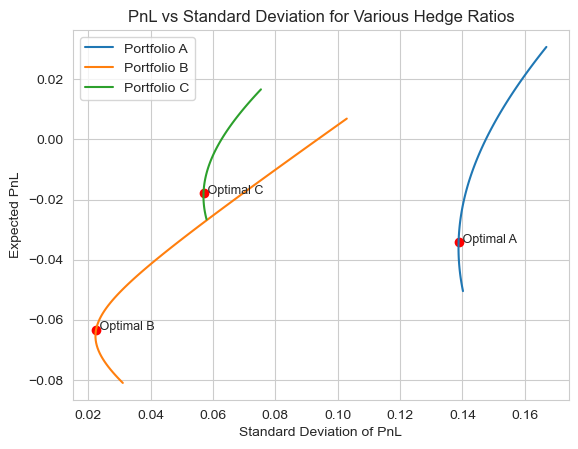

In [9]:
# Given covariance matrix components
sigma_pnl_11=cov_pnl1.iloc[0,0]
sigma_pnl_12=cov_pnl1.iloc[0,1:]

print(sigma_pnl_11)
print(sigma_pnl_12)


#CALCULATING THE HEDGE RATIO FOR EACH PORTFOLIO:
#Portfolio A:
h2_A=np.array([1,0,0,0])
optimal_h1_A=-np.dot(sigma_pnl_12,h2_A)/sigma_pnl_11
usd_exposure_A=(h2_A[0]+h2_A[2])*fx0
hr_A=optimal_h1_A/usd_exposure_A
"""weights_A=np.concatenate(([optimal_h1_A],h2_A))
port_std_A=np.sqrt(weights_A @ cov_pnl1 @ weights_A)
E_pnl_A=weights_A @ E_pnl1
"""

#Portfolio B:
h2_B=np.array([0,0,1,0])
optimal_h1_B=-np.dot(sigma_pnl_12,h2_B)/sigma_pnl_11
usd_exposure_B=(h2_A[0]+h2_A[2])*fx0
hr_B=optimal_h1_B/usd_exposure_B

#Portfolio C:
h2_C=np.array([0.2, 0.2, 0.3, 0.3])
optimal_h1_C=-np.dot(sigma_pnl_12,h2_C)/sigma_pnl_11
usd_exposure_C=(h2_A[0]+h2_A[2])*fx0
hr_C=optimal_h1_C/usd_exposure_C

print(hr_A,hr_B,hr_C)

portfolios = {
    'A': {'h2': np.array([1, 0, 0, 0]), 'hr': hr_A},
    'B': {'h2': np.array([0, 0, 1, 0]), 'hr': hr_B},
    'C': {'h2': np.array([0.2, 0.2, 0.3, 0.3]), 'hr': hr_C}
}


#PLOTTING the combinations of standard deviation and expected PnL for hedge ratios ranging from -1 to 1.5
hedge_ratios = np.linspace(-1, 1.5, 100)

# Define a function to compute PnL and variance for a given hedge ratio
def compute_metrics(h1, h2):
    h = np.concatenate(([h1], h2))
    expected_pnl = np.dot(h, E_pnl1)
    variance_pnl = np.dot(h.T, np.dot(cov_pnl1, h))
    std_dev_pnl = np.sqrt(variance_pnl)

    return expected_pnl, std_dev_pnl

# Initialize plots
fig, ax = plt.subplots()

# Plotting using dictionary
for portfolio, data in portfolios.items():
    pnl_data = np.array([compute_metrics(data['hr'] * x, data['h2']) for x in hedge_ratios])
    ax.plot(pnl_data[:, 1], pnl_data[:, 0], label=f'Portfolio {portfolio}')
    # Optimal point
    optimal_pnl, optimal_std = compute_metrics(data['hr'], data['h2'])
    ax.scatter(optimal_std, optimal_pnl, color='red')
    ax.text(optimal_std, optimal_pnl, f' Optimal {portfolio}', fontsize=9)

ax.set_xlabel('Standard Deviation of PnL')
ax.set_ylabel('Expected PnL')
ax.set_title('PnL vs Standard Deviation for Various Hedge Ratios')
ax.legend()
plt.grid(True)
plt.show()

## Question 8
For the multi-asset portfolio, describe how to find the minimum 5% CVaR hedge ratio. Plot the combinations of 5% CVaR and expected PnL for hedge ratios ranging from -1 to 1.5. What do you observe?


## Question 9
For the multi-asset portfolio, describe how to perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed. Consider a two year sample of the market invariants. Based on simulated covariance matrices, calculate optimal hedge ratios. Evaluate the simulated optimal hedge ratios using the true distributional parameters to visualize the resulting distributions of expected PnL, standard deviation, 5% CVaR, etc.


## Question 10
The investor is considering different portfolio optimization strategies for setting both the optimal asset weights and the optimal hedge ratio. The three possibilities are:

- Mean-Variance portfolio optimization using pre-specified hedge ratios equal to the asset specific optimal (minimum-variance) hedge ratios.
- Initial Mean-Variance portfolio optimization with a hedge ratio constrained to zero followed by choosing the hedge ratio as the minimum-variance hedge ratio.
- Full scale Mean-Variance portfolio optimization that allows the hedge ratio to be calculated directly.

Implement the three portfolio optimization strategies. A non-shorting constraint is imposed for the four assets, but not the forward contract. The investor has a budget of 1 EUR. For each strategy, the efficient frontier needs to be calculated for all possible PnL targets from the smallest to the largest. Present relevant visualizations and discuss your results.


## Question 11
Perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed for the three strategies (consider only one or two portfolios on the efficient frontier, e.g., the minimum-variance portfolio). Present and discuss relevant results.
